# Analysing the data and models

## Cleaning the data

In [1]:
import pandas as pd
import numpy as np

from nltk import FreqDist
import re

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

In [428]:
category = "books"

In [429]:
train_data = pd.read_csv('../data/full_data/'+category+'.csv')
train_data = train_data.set_index('uniq_id')
train_data = train_data.drop('Unnamed: 0', axis = 1)
train_data.head(3)

,product_name,summary,review_text,reviewer,helpful,rating,sentiment
uniq_id,,,,,,,
"1593760361:beautiful:krissy_""avid_reader""",Hannah Coulter: A Novel: Books: Wendell Berry,Beautiful,This book was stunning - I was enraptured with...,"Krissy ""Avid Reader""",0,5,1
"0312307411:laughs,_gasps,_aha's_and_oy_veys:m._stricks",Born to Kvetch: Yiddish Language and Culture i...,"Laughs, gasps, aha's and oy veys","Born to Kvetch is, at one time, informative, e...",M. Stricks,100,5,1
1417718544:vastly_over-written_and_vastly_over-praised:paul_cook,Independence Day: Books: Richard Ford,Vastly Over-Written and Vastly Over-Praised,"From the remarks at this site, people either l...",Paul Cook,66,2,0


In [430]:
train_data.describe()

,helpful,rating,sentiment
count,1998.000000,1998.000000,1998.000000
mean,53.227227,3.096597,0.500000
std,38.548273,1.701329,0.500125
min,0.000000,1.000000,0.000000
25%,14.000000,1.000000,0.000000
50%,54.000000,3.000000,0.500000
75%,100.000000,5.000000,1.000000
max,100.000000,5.000000,1.000000


In [431]:
def freq_words(x):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # Select top 20 most frequent words
    d = words_df.nlargest(columns="count", n = 20) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

In [432]:
# freq_words(train_data['review_text'])

In [8]:
rep_sym = re.compile('[/(){}\[\]\|@,;]')
rep_unw_sym = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))

train_data['summary'] = train_data['summary'].str.replace("[^a-zA-Z#]", " ")
train_data['review_text'] = train_data['review_text'].str.replace("[^a-zA-Z#]", " ")

In [6]:
def clean_text(text):
    
    # Change all text to lower to avoid ambiguity
    text = text.lower()
    
    # Replace all unwanted symbols by space in text
    text = rep_sym.sub(' ', text) 
    text = rep_unw_sym.sub('', text)
    
    # Remove stopwords from the sentences
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [435]:
# Cleaning the text for stop words
train_data['summary'] = train_data['summary'].apply(clean_text)
train_data['review_text'] = train_data['review_text'].apply(clean_text)

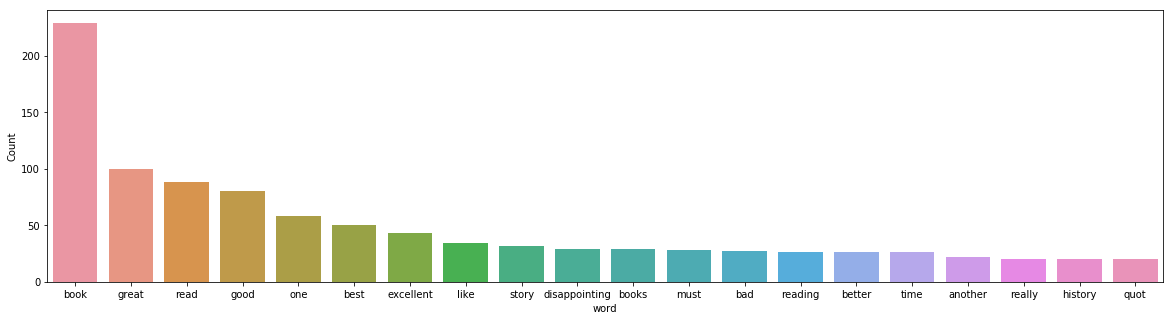

In [436]:
freq_words(train_data['summary'])

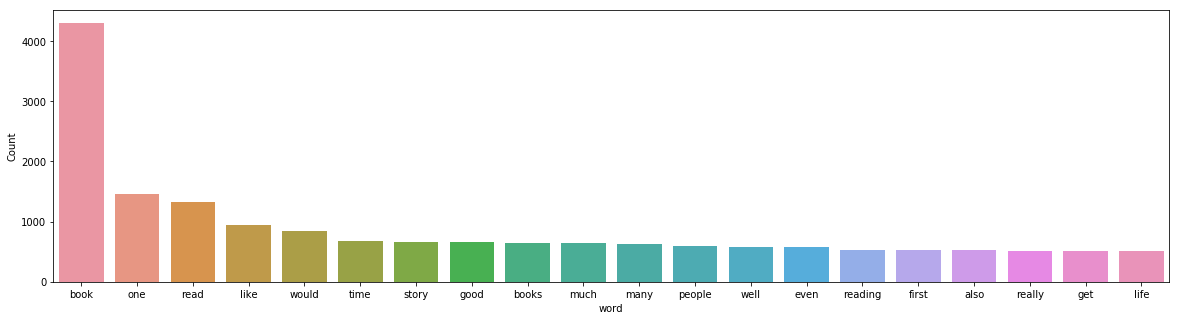

In [437]:
freq_words(train_data['review_text'])

## Training Various Models over the data

In [10]:
# Library to split the training data to train and test data
from sklearn.model_selection import train_test_split

# Library to convert the text into a matrix of TF-IDF and token count.
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Library to apply a pipeline of functions
from sklearn.pipeline import Pipeline

# Libraries to perform Learning on the data
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Library to evaluate the model predictions
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

/Users/rockstar/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Using only reviews

In [439]:
X_train_rev, X_test_rev, y_train, y_test = train_test_split(train_data.review_text,
                                                    train_data.sentiment,
                                                    test_size=0.25,
                                                    random_state = 42)

In [440]:
# Create the pipeline
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])

# Fit the training data on the model
nb.fit(X_train_rev, y_train)

# Predict the labels for the test data split using train test split
y_pred = nb.predict(X_test_rev)         

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.782
             precision    recall  f1-score   support

          0       0.75      0.84      0.79       246
          1       0.82      0.73      0.77       254

avg / total       0.79      0.78      0.78       500



In [441]:
# Create the pipeline
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])


# Fit the training data on the model
sgd.fit(X_train_rev, y_train)

# Predict the labels for the test data split using train test split
y_pred = sgd.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.788
             precision    recall  f1-score   support

          0       0.80      0.76      0.78       246
          1       0.78      0.82      0.80       254

avg / total       0.79      0.79      0.79       500



In [442]:
# Create the pipeline
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5))])

# Fit the training data on the model
logreg.fit(X_train_rev, y_train)

# Predict the labels for the test data split using train test split
y_pred = logreg.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.778
             precision    recall  f1-score   support

          0       0.78      0.76      0.77       246
          1       0.78      0.79      0.78       254

avg / total       0.78      0.78      0.78       500



In [443]:
# Create the pipeline
rfc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100))])

# Fit the training data on the model
rfc.fit(X_train_rev, y_train)

# Predict the labels for the test data split using train test split
y_pred = rfc.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.748
             precision    recall  f1-score   support

          0       0.74      0.74      0.74       246
          1       0.75      0.75      0.75       254

avg / total       0.75      0.75      0.75       500



### Using only Summary

In [154]:
X_train_sum, X_test_sum, y_train, y_test = train_test_split(train_data.summary,
                                                    train_data.sentiment,
                                                    test_size=0.25,
                                                    random_state = 42)

In [155]:
# Create the pipeline
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])

# Fit the training data on the model
nb.fit(X_train_sum, y_train)

# Predict the labels for the test data split using train test split
y_pred = nb.predict(X_test_sum)         

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.748
             precision    recall  f1-score   support

          0       0.74      0.72      0.73       236
          1       0.76      0.77      0.76       264

avg / total       0.75      0.75      0.75       500



In [156]:
# Create the pipeline
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])


# Fit the training data on the model
sgd.fit(X_train_sum, y_train)

# Predict the labels for the test data split using train test split
y_pred = sgd.predict(X_test_sum)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.744
             precision    recall  f1-score   support

          0       0.71      0.78      0.74       236
          1       0.78      0.71      0.75       264

avg / total       0.75      0.74      0.74       500



In [157]:
# Create the pipeline
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5))])

# Fit the training data on the model
logreg.fit(X_train_sum, y_train)

# Predict the labels for the test data split using train test split
y_pred = logreg.predict(X_test_sum)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7
             precision    recall  f1-score   support

          0       0.67      0.71      0.69       236
          1       0.73      0.69      0.71       264

avg / total       0.70      0.70      0.70       500



In [158]:
# Create the pipeline
rfc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100))])

# Fit the training data on the model
rfc.fit(X_train_sum, y_train)

# Predict the labels for the test data split using train test split
y_pred = rfc.predict(X_test_sum)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.738
             precision    recall  f1-score   support

          0       0.69      0.81      0.74       236
          1       0.80      0.68      0.73       264

avg / total       0.75      0.74      0.74       500



### Using both reviews and summary

In [159]:
cvec_rev = CountVectorizer(stop_words = "english").fit(X_train_rev)
cvec_sum = CountVectorizer(stop_words = "english").fit(X_train_sum)

In [160]:
rev_train = pd.DataFrame(cvec_rev.transform(X_train_rev).todense(), columns = cvec_rev.get_feature_names())
rev_test = pd.DataFrame(cvec_rev.transform(X_test_rev).todense(), columns = cvec_rev.get_feature_names())
sum_train = pd.DataFrame(cvec_sum.transform(X_train_sum).todense(), columns = cvec_sum.get_feature_names())
sum_test = pd.DataFrame(cvec_sum.transform(X_test_sum).todense(), columns = cvec_sum.get_feature_names())

In [161]:
X_train = pd.concat([rev_train, sum_train], axis = 1)
X_test = pd.concat([rev_test, sum_test], axis = 1)

In [162]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.842
             precision    recall  f1-score   support

          0       0.85      0.81      0.83       236
          1       0.84      0.87      0.85       264

avg / total       0.84      0.84      0.84       500



In [163]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.81
             precision    recall  f1-score   support

          0       0.79      0.81      0.80       236
          1       0.83      0.81      0.82       264

avg / total       0.81      0.81      0.81       500



In [164]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.804
             precision    recall  f1-score   support

          0       0.81      0.77      0.79       236
          1       0.80      0.84      0.82       264

avg / total       0.80      0.80      0.80       500



In [165]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)         
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.804
             precision    recall  f1-score   support

          0       0.80      0.78      0.79       236
          1       0.81      0.82      0.82       264

avg / total       0.80      0.80      0.80       500



## Review Classification

### Using only reviews

In [444]:
X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(train_data.review_text,
                                                    train_data.rating,
                                                    test_size=0.25,
                                                    random_state = 42)

In [445]:
# Create the pipeline
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])

# Fit the training data on the model
nb.fit(X_train_rev, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = nb.predict(X_test_rev)         

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.444
             precision    recall  f1-score   support

          1       0.67      0.25      0.36       126
          2       1.00      0.02      0.03       120
          4       0.00      0.00      0.00        64
          5       0.42      0.99      0.59       190

avg / total       0.57      0.44      0.32       500



/Users/rockstar/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [446]:
# Create the pipeline
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])


# Fit the training data on the model
sgd.fit(X_train_rev, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = sgd.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.552
             precision    recall  f1-score   support

          1       0.53      0.63      0.58       126
          2       0.50      0.23      0.32       120
          4       0.50      0.05      0.09        64
          5       0.57      0.87      0.69       190

avg / total       0.54      0.55      0.50       500



In [447]:
# Create the pipeline
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5))])

# Fit the training data on the model
logreg.fit(X_train_rev, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = logreg.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test, y_pred))

accuracy 0.54
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       246
          1       0.19      0.10      0.13       254
          2       0.00      0.00      0.00         0
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         0

avg / total       0.10      0.05      0.07       500



/Users/rockstar/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rockstar/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [448]:
# Create the pipeline
rfc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100))])

# Fit the training data on the model
rfc.fit(X_train_rev, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = rfc.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.524
             precision    recall  f1-score   support

          1       0.48      0.56      0.52       126
          2       0.68      0.21      0.32       120
          4       1.00      0.02      0.03        64
          5       0.52      0.87      0.65       190

avg / total       0.61      0.52      0.46       500



In [449]:
# Create the pipeline
dt = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])

# Fit the training data on the model
dt.fit(X_train_rev, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = dt.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.376
             precision    recall  f1-score   support

          1       0.35      0.39      0.37       126
          2       0.30      0.33      0.31       120
          4       0.20      0.12      0.15        64
          5       0.49      0.48      0.49       190

avg / total       0.37      0.38      0.37       500



In [450]:
# Create the pipeline
knn = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])

# Fit the training data on the model
dt.fit(X_train_rev, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = dt.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.368
             precision    recall  f1-score   support

          1       0.31      0.36      0.33       126
          2       0.32      0.29      0.30       120
          4       0.22      0.20      0.21        64
          5       0.49      0.48      0.48       190

avg / total       0.37      0.37      0.37       500



In [451]:
# Create the pipeline
ada = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(n_estimators=100))])

# Fit the training data on the model
ada.fit(X_train_rev, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = ada.predict(X_test_rev)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.432
             precision    recall  f1-score   support

          1       0.41      0.36      0.38       126
          2       0.41      0.34      0.37       120
          4       0.35      0.14      0.20        64
          5       0.46      0.64      0.53       190

avg / total       0.42      0.43      0.41       500



### Using only summary

In [265]:
X_train_sum, X_test_sum, y_train_sum, y_test_sum = train_test_split(train_data.summary,
                                                    train_data.rating,
                                                    test_size=0.25,
                                                    random_state = 42)

In [266]:
# Create the pipeline
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB())])

# Fit the training data on the model
nb.fit(X_train_sum, y_train_sum)

# Predict the labels for the test data split using train test split
y_pred = nb.predict(X_test_sum)         

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_sum))
print(classification_report(y_test_sum, y_pred))

accuracy 0.574
             precision    recall  f1-score   support

          1       0.58      0.66      0.62       175
          2       0.25      0.01      0.03        73
          4       0.50      0.02      0.03        56
          5       0.57      0.86      0.69       196

avg / total       0.52      0.57      0.49       500



In [267]:
# Create the pipeline
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])


# Fit the training data on the model
sgd.fit(X_train_sum, y_train_sum)

# Predict the labels for the test data split using train test split
y_pred = sgd.predict(X_test_sum)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_sum))
print(classification_report(y_test_sum, y_pred))

accuracy 0.556
             precision    recall  f1-score   support

          1       0.55      0.73      0.62       175
          2       0.24      0.10      0.14        73
          4       0.17      0.07      0.10        56
          5       0.65      0.71      0.68       196

avg / total       0.50      0.56      0.52       500



In [268]:
# Create the pipeline
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5))])

# Fit the training data on the model
logreg.fit(X_train_sum, y_train_sum)

# Predict the labels for the test data split using train test split
y_pred = logreg.predict(X_test_sum)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_sum))
print(classification_report(y_test_sum, y_pred))

accuracy 0.494
             precision    recall  f1-score   support

          1       0.52      0.57      0.54       175
          2       0.21      0.16      0.18        73
          4       0.21      0.21      0.21        56
          5       0.64      0.63      0.63       196

avg / total       0.49      0.49      0.49       500



In [269]:
# Create the pipeline
rfc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100))])

# Fit the training data on the model
rfc.fit(X_train_sum, y_train_sum)

# Predict the labels for the test data split using train test split
y_pred = rfc.predict(X_test_sum)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_sum))
print(classification_report(y_test_sum, y_pred))

accuracy 0.516
             precision    recall  f1-score   support

          1       0.49      0.69      0.57       175
          2       0.26      0.19      0.22        73
          4       0.34      0.18      0.24        56
          5       0.66      0.58      0.62       196

avg / total       0.51      0.52      0.50       500



### Using both reviews and summary

In [270]:
cvec_rev = CountVectorizer(stop_words = "english").fit(X_train_rev)
cvec_sum = CountVectorizer(stop_words = "english").fit(X_train_sum)

In [271]:
rev_train = pd.DataFrame(cvec_rev.transform(X_train_rev).todense(), columns = cvec_rev.get_feature_names())
rev_test = pd.DataFrame(cvec_rev.transform(X_test_rev).todense(), columns = cvec_rev.get_feature_names())
sum_train = pd.DataFrame(cvec_sum.transform(X_train_sum).todense(), columns = cvec_sum.get_feature_names())
sum_test = pd.DataFrame(cvec_sum.transform(X_test_sum).todense(), columns = cvec_sum.get_feature_names())

In [272]:
X_train = pd.concat([rev_train, sum_train], axis = 1)
X_test = pd.concat([rev_test, sum_test], axis = 1)

In [273]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(X_train, y_train_rev)
y_pred = rfc.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.664
             precision    recall  f1-score   support

          1       0.64      0.89      0.75       175
          2       1.00      0.03      0.05        73
          4       0.67      0.04      0.07        56
          5       0.68      0.88      0.77       196

avg / total       0.71      0.66      0.58       500



In [274]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train_rev)
y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.616
             precision    recall  f1-score   support

          1       0.70      0.72      0.71       175
          2       0.29      0.23      0.26        73
          4       0.25      0.23      0.24        56
          5       0.73      0.78      0.75       196

avg / total       0.60      0.62      0.61       500



In [275]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train_rev)
y_pred = sgd.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.632
             precision    recall  f1-score   support

          1       0.68      0.72      0.70       175
          2       0.27      0.26      0.26        73
          4       0.39      0.34      0.36        56
          5       0.78      0.78      0.78       196

avg / total       0.63      0.63      0.63       500



In [276]:
nb = MultinomialNB()
nb.fit(X_train, y_train_rev)
y_pred = nb.predict(X_test)         
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.67
             precision    recall  f1-score   support

          1       0.69      0.75      0.72       175
          2       0.39      0.15      0.22        73
          4       0.50      0.05      0.10        56
          5       0.69      0.96      0.80       196

avg / total       0.62      0.67      0.61       500



## Using Advanced Techniques

In [277]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

In [278]:
# Create the pipeline
dt = DecisionTreeClassifier()

# Fit the training data on the model
dt.fit(X_train, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = dt.predict(X_test)         

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.508
             precision    recall  f1-score   support

          1       0.58      0.57      0.57       175
          2       0.20      0.21      0.20        73
          4       0.22      0.20      0.21        56
          5       0.64      0.66      0.65       196

avg / total       0.51      0.51      0.51       500



In [279]:
# Create the pipeline
knn = KNeighborsClassifier()


# Fit the training data on the model
knn.fit(X_train, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = knn.predict(X_test)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.306
             precision    recall  f1-score   support

          1       0.44      0.42      0.43       175
          2       0.13      0.11      0.12        73
          4       0.09      0.29      0.14        56
          5       0.54      0.28      0.37       196

avg / total       0.40      0.31      0.33       500



In [280]:
# Create the pipeline
adb = AdaBoostClassifier(n_estimators=100)

# Fit the training data on the model
adb.fit(X_train, y_train_rev)

# Predict the labels for the test data split using train test split
y_pred = adb.predict(X_test)

# Evaluate the results
print('accuracy %s' % accuracy_score(y_pred, y_test_rev))
print(classification_report(y_test_rev, y_pred))

accuracy 0.564
             precision    recall  f1-score   support

          1       0.58      0.72      0.64       175
          2       0.06      0.04      0.05        73
          4       0.44      0.27      0.33        56
          5       0.70      0.70      0.70       196

avg / total       0.54      0.56      0.54       500



## Prediction

In [14]:
test_data = pd.read_csv('../data/test_data/test_electronics.csv')
test_data = test_data.set_index('uniq_id')
test_data = test_data.drop('Unnamed: 0', axis = 1)
test_data.head(3)

,product_name,summary,review_text,reviewer,helpful
uniq_id,,,,,
B0001IXUEY:good_purchase:r._latham,Panasonic RX-D29 CD / Radio / Cassette Boombox...,good purchase,couldn't find a boombox that was lightweight b...,R. Latham,83
B00005UKBG:it_does_the_job:diane_m._chalmers,"Atlantic 1316 CD Storage Case (110-Capacity, W...",It does the job,I have never had this device fall over like ot...,Diane M. Chalmers,100
"B00006IC4E:excellent,_but_fragile:geoffrey_levine",Fellowes 21100 Book Lift Holder (Silver): Elec...,"excellent, but fragile",It worked much better than expected. The page ...,Geoffrey Levine,100


In [2]:
def getTrainData(category):
    train_data = pd.read_csv('../data/full_data/'+category+'.csv')
    train_data = train_data.set_index('uniq_id')
    train_data = train_data.drop('Unnamed: 0', axis = 1)
    return train_data

In [3]:
def clean_data(train_data):
    train_data['summary'] = train_data['summary'].str.replace("[^a-zA-Z#]", " ")
    train_data['review_text'] = train_data['review_text'].str.replace("[^a-zA-Z#]", " ")
    train_data['summary'] = train_data['summary'].apply(clean_text)
    train_data['review_text'] = train_data['review_text'].apply(clean_text)

    return train_data

In [4]:
def split_data(train_data, output):
    X_train, X_test, y_train, y_test = train_test_split(train_data.review_text,
                                                        output,
                                                        test_size=0.25,
                                                        random_state = 42)
    return (X_train, X_test, y_train, y_test)

In [24]:
categories = ['books', 'dvd', 'electronics', 'kitchen_housewares']
data_train = pd.DataFrame()
for cat in categories:
    train_data = getTrainData(cat)
    train_data = clean_data(train_data)
    #data_train = pd.concat([data_train, train_data], axis = 1)
    data_train = data_train.append(train_data)
X_train, X_test, y_train, y_test = split_data(data_train, data_train.sentiment)

In [25]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))])

In [26]:
test_data = clean_data(test_data)

In [27]:
# cvec_rev = CountVectorizer(stop_words = "english").fit(test_data.review_text)
# cvec_sum = CountVectorizer(stop_words = "english").fit(test_data.summary)
# test_rev = pd.DataFrame(cvec_rev.transform(test_data.review_text).todense(), columns = cvec_rev.get_feature_names())
# test_sum = pd.DataFrame(cvec_sum.transform(test_data.summary).todense(), columns = cvec_sum.get_feature_names())

# test_X = pd.concat([test_rev, test_sum], axis = 1)

In [28]:
sgd.fit(X_train, y_train)
y_prediction = sgd.predict(test_data.review_text)

In [494]:
sol_data = pd.DataFrame({'uniq_id':test_data.index, 'sentiment':y_prediction})

In [495]:
X_train, X_test, y_train, y_test = split_data(data_train, data_train.rating)
sgd.fit(X_train, y_train)
y_pred2 = sgd.predict(test_data.review_text)

In [496]:
sol_data = pd.DataFrame({'uniq_id':test_data.index, 'rating': y_pred2, 'sentiment':y_prediction})

In [497]:
sol_data = sol_data.set_index('uniq_id')

In [498]:
sol_data.sample(10)

,rating,sentiment
uniq_id,,
"B00008SCFU:excellent_product,_and_i_received_it_free!:just_me",5,1
B00009YUPS:don't_buy.__terrible_terrible_product:dr._marc_mayerson,1,0
B00005UKBG:nice_rack:charles_m._miller,5,1
"B0009O5MWI:awesome_value!!_highly_recommend!:s._tucker_""dance_freak""",5,1
B00008RW8B:excellent_and_portable_memory_card_reader:d-m-a,5,1
B00006HYUB:don't_risk_being_without_one!:theresa_l._smith,1,0
B00008SCFU:rcarrier:ronald_r._carrier,5,1
B00006IC4E:great_little_product!:jigga,5,1
B0001IXUEY:perfect_for_my_needs:vask,5,1


In [499]:
sol_data.to_csv('../predictions/electronics.csv')